# Cluster Analysis of Text Data
The work compares two methods for topic analysis of COVID-19 articles.  

Dataset: COVID-19 Open Research Dataset Challenge (CORD-19)
 https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge  
 
Overview:
1. Import and clean the data
1. Use TF-IDF with K-Means to cluster the articles
1. Use sentence embeddings with K-Means to cluster the articles
1. Compare clustering metrics between the two methodologes
1. Compare feature importance between the two methodologes

In [ ]:
!pip install sentence_transformers

In [48]:
import numpy as np 
import pandas as pd 
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random

# Data loading and preprocessing

In [3]:
df = pd.read_csv('../input/CORD-19-research-challenge/metadata.csv')
df.head()

/tmp/ipykernel_32/3232715335.py:1: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../input/CORD-19-research-challenge/metadata.csv')


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821118 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null   object 
 14  arxiv_id          14249 non-null    object 
 15  pdf_json_files    373766 non-null   object 
 16  

In [5]:
df.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

In [6]:
df = df[['cord_uid', 'source_x', 'title', 'publish_time', 'abstract','journal']]

In [7]:
df.publish_time = pd.to_datetime(df.publish_time)
df.publish_time.dt.year.value_counts()

2021.0    453225
2020.0    375635
2022.0    128431
2019.0      9221
2016.0      8049
           ...  
1879.0         1
1910.0         1
1891.0         1
1916.0         1
1944.0         1
Name: publish_time, Length: 123, dtype: int64

In [8]:
# use only recent data
df = df[df.publish_time.dt.year == 2021]
len(df)

453225

In [9]:
len(df.dropna(subset=['abstract'])) / len(df)

0.8073142478901209

In [10]:
# drop rows with missing key data
df = df.dropna(subset=['abstract', 'title'])
df = df.reset_index(drop=True)
len(df)

365839

In [11]:
# downsampling to reduce processing time since this is a POC
df = df.sample(frac=.1).reset_index(drop=True)
len(df)

36584

In [12]:
combined_text = df.apply(lambda x: re.sub(r'[^a-z A-Z]', '', x.title + ' ' + x.abstract), axis=1)
combined_text[0]

'OP Efficacy and safety of upadacitinib as induction therapy in patients with Moderately to Severely Active Ulcerative Colitis Results from phase  UACCOMPLISH study BACKGROUND Upadacitinib UPA is a selective and reversible Janus kinase inhibitorUACCOMPLISH is one of two phase  induction trials that evaluated the safety and efficacy of UPA  mg once daily QD in adults with ulcerative colitis UC METHODS UACCOMPLISH was a multicentre randomized doubleblind placebocontrolled trial NCT that enrolled patients with moderatetosevere UC defined as adapted Mayo score  with centrally read endoscopic score  who had inadequate response loss of response or intolerance to aminosalicylates immunosuppressants corticosteroids andor biologics Patients were randomized  to UPA  mg QD or placebo PBO for  weeks At week  responders entered the maintenance phase and nonresponders entered the extended treatment period to receive openlabel UPA  mg QD for additional  weeksThe primary endpoint clinical remission pe

In [13]:
len(combined_text)

36584

# Use TF-IDF with K-Means to cluster the articles

In [36]:
vectorizer = TfidfVectorizer(
    max_df=.5,
    min_df=5,
    stop_words='english',
    token_pattern= r'(?ui)\b\w*[a-z]+\w*\b|[^\w\s]+' #'(?ui)\\b\\w*[a-z]+\\w*\\b' # customized to remove numbers
)

X_tfidf = vectorizer.fit_transform(combined_text)
print(f'num samples: {X_tfidf.shape[0]}')
print(f'num features: {X_tfidf.shape[1]}')
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

num samples: 36584
num features: 28235
0.003


In [37]:
vectorizer.get_feature_names_out()[:20]

array(['aa', 'aaa', 'aaas', 'aace', 'aamc', 'aas', 'aav', 'ab', 'aba',
       'ababa', 'abandon', 'abandoned', 'abandonment', 'abatacept',
       'abate', 'abated', 'abatement', 'abbott', 'abbreviated',
       'abbreviations'], dtype=object)

Text(0.5, 1.0, 'Topic Groupings using TF-IDF')

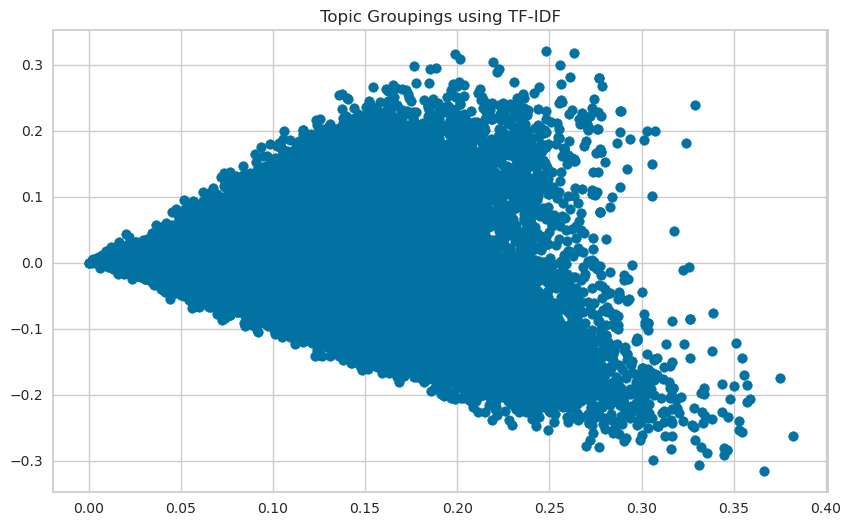

In [38]:
n_components = 2
svd = TruncatedSVD(n_components=n_components)
svd_matrix = svd.fit_transform(X_tfidf)

plt.figure(figsize=(10,6))
plt.scatter(svd_matrix[:, 0], svd_matrix[:, 1])
plt.title('Topic Groupings using TF-IDF')

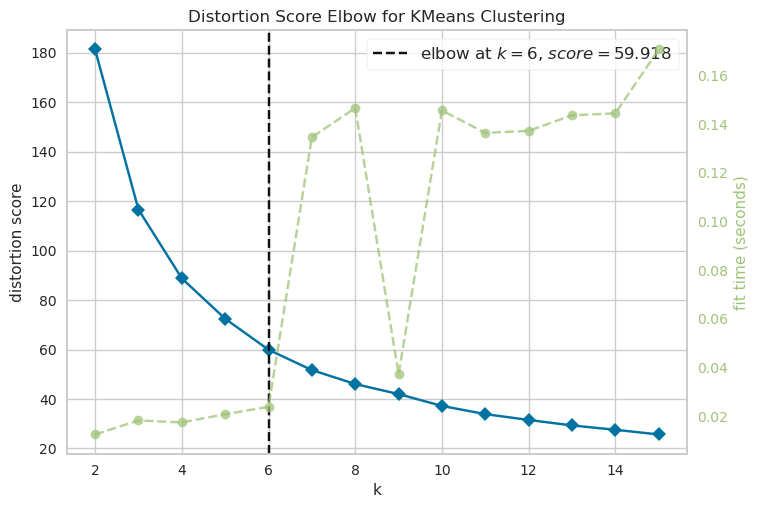

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
kmeans = KMeans(max_iter=100, random_state=42, n_init='auto')
visualizer = KElbowVisualizer(kmeans, k=(2, 16))
visualizer.fit(svd_matrix)
visualizer.show()

In [40]:
kmeans = KMeans(max_iter=300, random_state=42, n_init='auto', n_clusters=6)
labels = kmeans.fit_predict(svd_matrix)
labels[:20]

array([2, 4, 4, 0, 4, 4, 4, 5, 5, 5, 0, 2, 2, 4, 4, 3, 5, 2, 5, 3],
      dtype=int32)

Text(0.5, 1.0, 'Topic Groupings using TF-IDF')

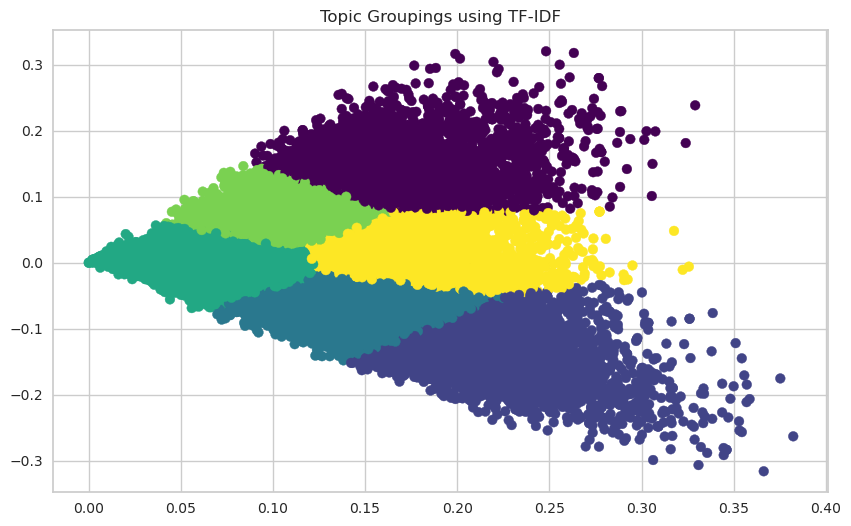

In [41]:
plt.figure(figsize=(10,6))
plt.scatter(svd_matrix[:,0], svd_matrix[:,1], c=labels, cmap='viridis')
plt.title('Topic Groupings using TF-IDF')

In [42]:
# def get_tfidf_top_features(documents,n_top=10):
#   tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,  stop_words='english')
#   tfidf = tfidf_vectorizer.fit_transform(documents)
#   importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
#   tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())
#   return tfidf_feature_names[importance[:n_top]]

word_importance = np.argsort(np.asarray(X_tfidf.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(vectorizer.get_feature_names_out())
tfidf_feature_names[word_importance[:5]]

array(['patients', 'pandemic', 'sarscov', 'health', 'study'], dtype=object)

In [43]:
def get_topics(tfidf, features, cluster_labels, n_words):
    import_topic_words = {}
    for cluster_id in set(cluster_labels):
        indices = np.where(cluster_labels == cluster_id)
        word_importance = np.argsort(np.asarray(tfidf[indices[0]].sum(axis=0)).ravel())[::-1]
        import_topic_words[cluster_id] = features[word_importance[:n_words]]
    return import_topic_words

import_topic_words = get_topics(X_tfidf, features=np.array(vectorizer.get_feature_names_out()), cluster_labels=labels, n_words=5)
for cluster_id in set(labels):
    print(f'cluster {cluster_id}: ' + ', '.join(import_topic_words[cluster_id]))

cluster 0: health, students, pandemic, mental, social
cluster 1: patients, sarscov, disease, infection, mortality
cluster 2: sarscov, patients, infection, disease, respiratory
cluster 3: using, la, cells, study, model
cluster 4: pandemic, health, research, social, data
cluster 5: patients, pandemic, care, health, study


In [44]:
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [45]:
fit_and_evaluate(kmeans, svd_matrix)

clustering done in 0.05 ± 0.02 s 
Homogeneity: 0.957 ± 0.042
Completeness: 0.957 ± 0.041
V-measure: 0.957 ± 0.042
Adjusted Rand-Index: 0.959 ± 0.046
Silhouette Coefficient: 0.368 ± 0.004


# Now use a pretrained sentence transformer embedding model with K-Means to cluster the articles
Information on the pretrained model: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [46]:
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
embeddings[0,:10]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([ 0.0676569 ,  0.06349595,  0.0487131 ,  0.07930497,  0.03744807,
        0.00265283,  0.03937495, -0.00709842,  0.05936148,  0.03153701],
      dtype=float32)

In [49]:
stopwords_list = stopwords.words('english')
stopwords_list = set(stopwords_list)

In [50]:
# must apply manual cleaning since not taking advantage of the cleaning provided by TfidVectorizer
combined_text_clean = combined_text.apply(lambda x: x.strip().lower())
combined_text_clean = combined_text_clean.apply(lambda x: word_tokenize(x))
combined_text_clean = combined_text_clean.apply(lambda x: [w for w in x if w not in stopwords_list])
combined_text_clean[:10]

0    [op, efficacy, safety, upadacitinib, induction...
1    [technology, acceptance, behavior, feedback, l...
2    [research, letters, conducted, online, survey,...
3    [videobased, learning, learning, home, solutio...
4    [stop, sanitizing, project, management, educat...
5    [enhancing, data, linkage, break, chain, covid...
6    [implementing, stratified, vocational, advice,...
7    [study, protocol, assess, respiratory, health,...
8    [telemedicine, malignant, nonmalignant, hemato...
9    [characteristics, providerfocused, research, c...
dtype: object

In [51]:
text_embeddings = model.encode(combined_text_clean)

Batches:   0%|          | 0/1144 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Topic Groupings using embeddings')

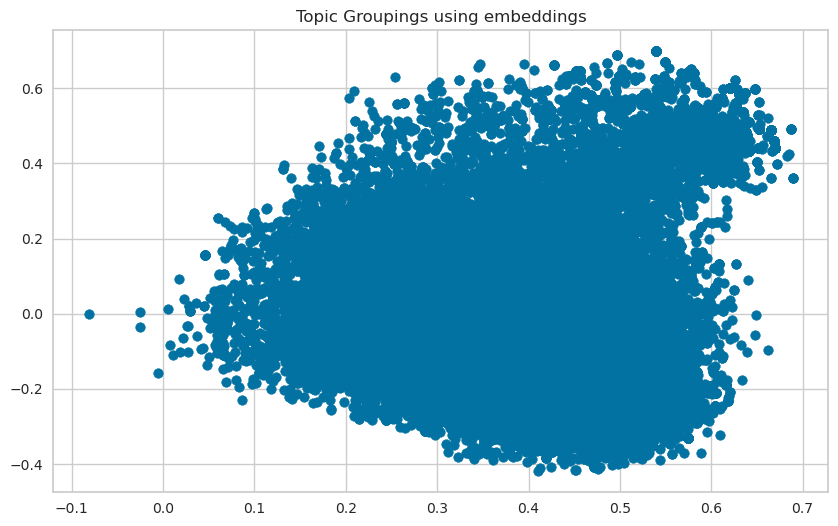

In [52]:
n_components = 2
svd = TruncatedSVD(n_components=n_components)
svd_matrix = svd.fit_transform(text_embeddings)

plt.figure(figsize=(10,6))
plt.scatter(svd_matrix[:, 0], svd_matrix[:, 1])
plt.title('Topic Groupings using embeddings')

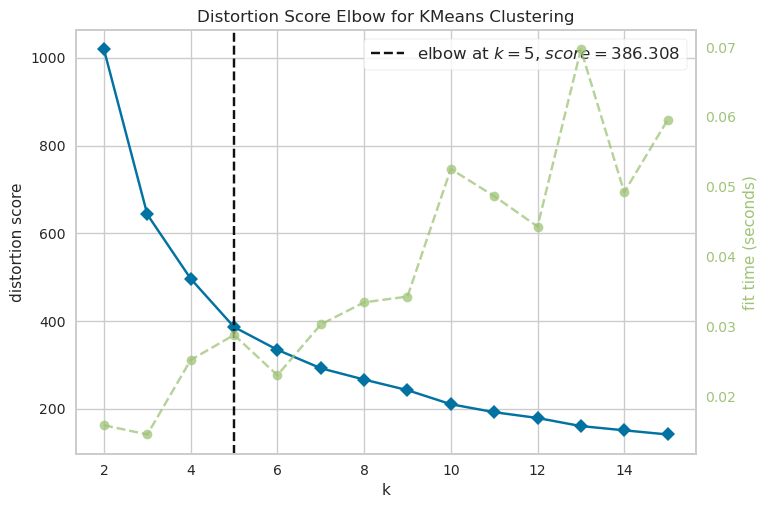

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [53]:
kmeans = KMeans(max_iter=100, random_state=42, n_init='auto')
visualizer = KElbowVisualizer(kmeans, k=(2, 16))
visualizer.fit(svd_matrix)
visualizer.show()

In [62]:
kmeans = KMeans(max_iter=300, random_state=42, n_init='auto', n_clusters=5)
labels = kmeans.fit_predict(svd_matrix)
labels[:20]

array([1, 0, 0, 0, 1, 0, 4, 0, 3, 4, 1, 1, 3, 0, 4, 4, 2, 1, 1, 3],
      dtype=int32)

Text(0.5, 1.0, 'Topic Groupings using embeddings')

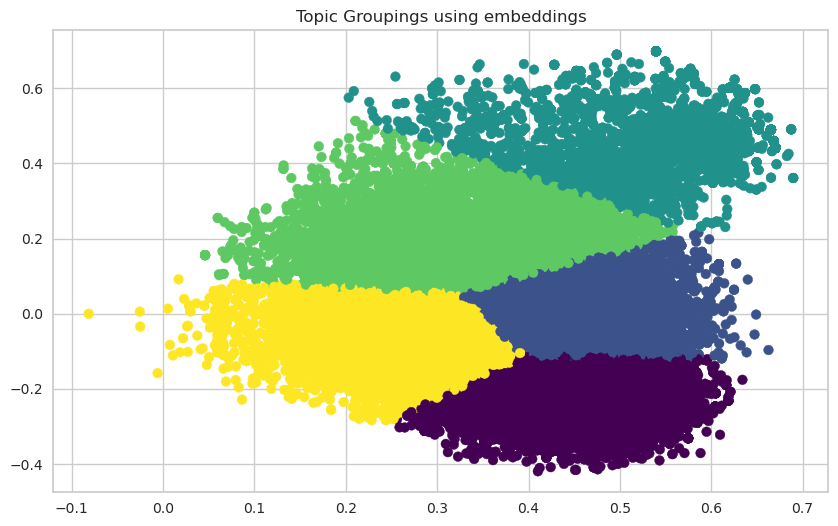

In [63]:
plt.figure(figsize=(10,6))
plt.scatter(svd_matrix[:,0], svd_matrix[:,1], c=labels, cmap='viridis')
plt.title('Topic Groupings using embeddings')

In [64]:
fit_and_evaluate(kmeans, svd_matrix)

clustering done in 0.04 ± 0.02 s 
Homogeneity: 0.925 ± 0.017
Completeness: 0.925 ± 0.017
V-measure: 0.925 ± 0.017
Adjusted Rand-Index: 0.937 ± 0.017
Silhouette Coefficient: 0.390 ± 0.006


In [65]:
import_topic_words = get_topics(X_tfidf, features=np.array(vectorizer.get_feature_names_out()), cluster_labels=labels, n_words=5)
for cluster_id in set(labels):
    print(f'cluster {cluster_id}: ' + ', '.join(import_topic_words[cluster_id]))

cluster 0: pandemic, health, study, patients, social
cluster 1: patients, health, pandemic, sarscov, care
cluster 2: pandemic, patients, health, sarscov, impact
cluster 3: patients, sarscov, infection, disease, severe
cluster 4: patients, sarscov, pandemic, study, health


# Conclusion
The parity in clustering metrics and topics are on par with eachother. The TF-IDF approach resulted in an additional cluster after using k-means relative to the sentence embedding approach, with the documents within cluster 3 being focused on research of COVID effects at the cellular level. This is a bit surprising since sentence-transformer models promise results from the latest in research. The lack of increased performance with the sentence transformer model may have been due to truncation, the model truncates input sentences longer than 256 words. The sentence transformer model may also have performed better with the full dataset (the dataset was downsampled to 10% of original in the interest of time).

This work shows that classical techniques such as TF-IDF can still result in promising results depending upon the use case.